In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import mean_squared_error,r2_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import datetime as dt
tf.random.set_seed(0)

In [18]:
data = pd.read_csv(r"D:\Data Science\datasets\CSV.csv")
data.head()

Date       Open       High        Low      Close  Adj Close  Volume
0  2022-07-12  39.250000  39.759998  39.090000  39.169998  38.554962   66100
1  2022-07-13  39.000000  39.340000  38.680000  39.080002  38.466373   70200
2  2022-07-14  38.549999  39.689999  38.450001  39.320000  38.702606   60400
3  2022-07-15  39.980000  40.869999  39.669998  40.389999  39.755806   65800
4  2022-07-18  40.849998  41.009998  39.439999  39.599998  38.978210   47800

In [19]:
dataset_summary = pd.DataFrame({"Date" : "The date on which trade occured", "Open" : "Day's Opening trading price", "High" : "Day's highest trading price",
                   "Low" : "Day's lowest trading price", "Close*" : "Day's Closing trading price", "Adj Close**" : "Day's Closing trading price after adjustustments",
                   "Volume" : "Quantity of stocks sold between open and close"},index=["Description"])
display(pd.DataFrame.transpose(dataset_summary))

Description
Date                          The date on which trade occured
Open                              Day's Opening trading price
High                              Day's highest trading price
Low                                Day's lowest trading price
Close*                            Day's Closing trading price
Adj Close**  Day's Closing trading price after adjustustments
Volume         Quantity of stocks sold between open and close

In [20]:
# #sns.heatmap(data.corr(),annot=True)
# fig = plt.figure(figsize=(15,10))

# for i in range(1,len(data.columns)):    
#     plt.subplot(3,2,i)
#     plt.scatter(data['Date'],data[data.columns[i]])
#     plt.xlabel('Date')
#     plt.ylabel(data.columns[i])
# plt.show()

In [21]:
open_price = data[['High']].values.astype('float32')
ss = MinMaxScaler(feature_range=(0,1))
open_price = ss.fit_transform(open_price)
#plt.plot(open_price)

In [22]:
train_size = round(len(open_price)*0.66)
test_size = len(open_price) - train_size
train, test = open_price[:train_size], open_price[train_size:len(open_price)]

In [23]:
def create_dataset(dataset, lookback):
    X, y = [], []

    for i in range(len(dataset)-lookback-1):
        X.append(dataset[i:i+lookback])
        y.append(dataset[i+lookback])
    
    return np.array(X), np.array(y)

In [24]:
lookback = 6 # 6
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(159, 6, 1) (159, 1)
(78, 6, 1) (78, 1)


In [25]:
dropout = 0.2

model = Sequential()
model.add(LSTM(100,input_shape=(lookback,1))) #100
model.add(Dropout(dropout))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,epochs=500,batch_size=32,verbose=2) #500 #32 96,77

Epoch 1/500
5/5 - 4s - loss: 0.1491 - 4s/epoch - 736ms/step
Epoch 2/500
5/5 - 0s - loss: 0.0498 - 69ms/epoch - 14ms/step
Epoch 3/500
5/5 - 0s - loss: 0.0138 - 76ms/epoch - 15ms/step
Epoch 4/500
5/5 - 0s - loss: 0.0234 - 83ms/epoch - 17ms/step
Epoch 5/500
5/5 - 0s - loss: 0.0124 - 74ms/epoch - 15ms/step


KeyboardInterrupt: 

In [ ]:
train_pred = model.predict(X_train)
test_pred = model(X_test)
train_pred = ss.inverse_transform(train_pred)
test_pred = ss.inverse_transform(test_pred)
y_train = ss.inverse_transform(y_train)
y_test = ss.inverse_transform(y_test)

train_rmse = np.round(np.sqrt(mean_squared_error(y_train,train_pred)),2)
test_rmse = np.round(np.sqrt(mean_squared_error(y_test,test_pred)),2)

train_acc = np.round(r2_score(y_train,train_pred),2)
test_acc = np.round(r2_score(y_test,test_pred),2)

print(f"Train RMSE : {train_rmse}, Train accuracy : {train_acc}")
print(f"Test RMSE : {test_rmse}, Test accuracy : {test_acc}")

5/5 [==============================] - 1s 3ms/step
Train RMSE : 0.9599999785423279, Train accuracy : 0.96
Test RMSE : 0.97, Test accuracy : 0.77


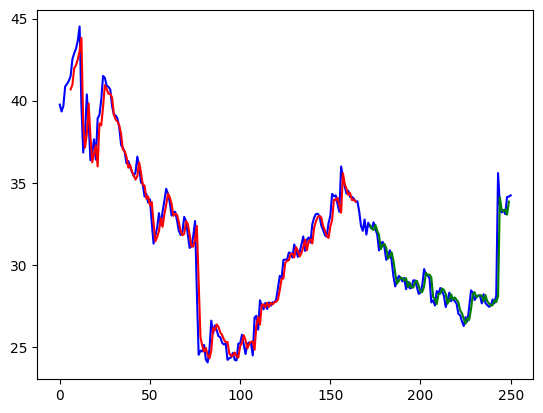

In [ ]:
# shift train predictions for plotting
train_plot = np.ones_like(open_price) * np.nan
# print(len(train_pred))
# print(train_plot.shape)
# print(train_pred.shape)
open_price = ss.inverse_transform(open_price)
train_plot[lookback:train_size-1] = train_pred
# shift test predictions for plotting
test_plot = np.ones_like(open_price) * np.nan
test_plot[train_size+lookback:len(open_price)-1] = test_pred
# plot
plt.plot(open_price, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
#print(test_plot[75:])
#print(open_price)
plt.show()

In [28]:
train_plot[lookback:train_size-1].shape

(159, 1)

## Appendix

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/